In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [33]:
import yaml
import definitions

with open(definitions.get_config_path()) as f:
  config = yaml.safe_load(f)

  root = definitions.get_project_root()
  data_dir = root / config['data path'] / 'dogs-vs-cats'
  batch_size = 32
  img_height = config['size x']
  img_width = config['size y']
  model_file_path = root / config['model path']

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


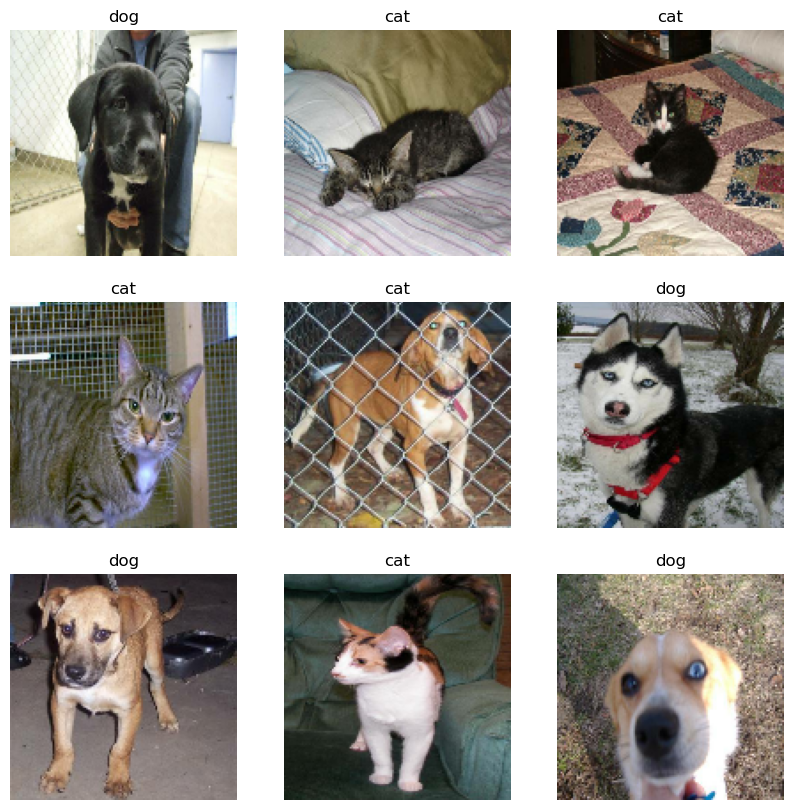

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

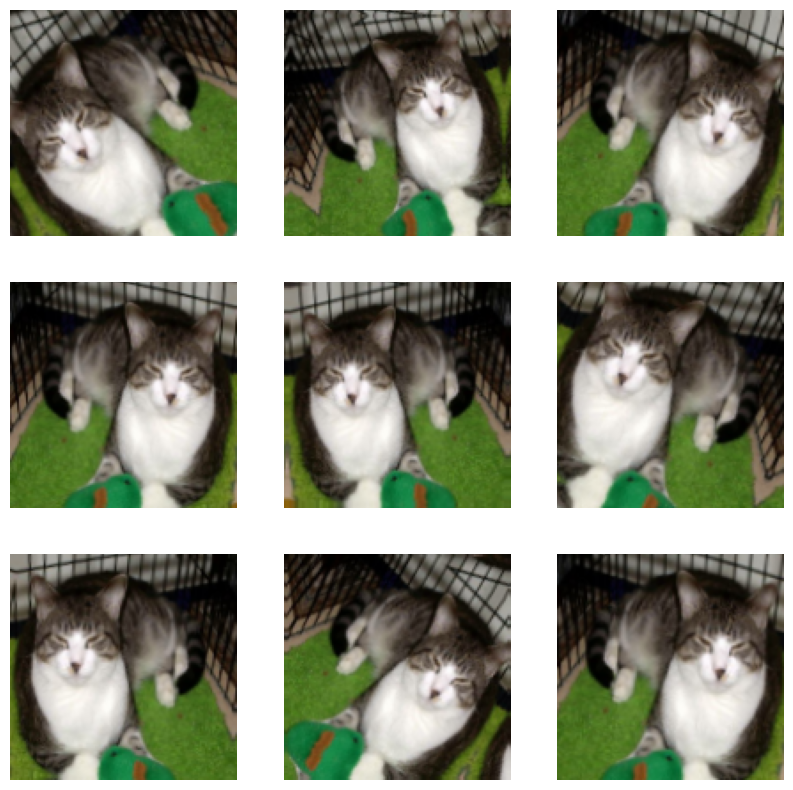

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation, # <= image augmentation
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # <= before training
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
250/250 [==============================] - 115s 429ms/step - loss: 0.6800 - accuracy: 0.5732 - val_loss: 0.6394 - val_accuracy: 0.6605
Epoch 2/15
250/250 [==============================] - 108s 431ms/step - loss: 0.6180 - accuracy: 0.6622 - val_loss: 0.6176 - val_accuracy: 0.6790
Epoch 3/15
250/250 [==============================] - 108s 432ms/step - loss: 0.5852 - accuracy: 0.6957 - val_loss: 0.5676 - val_accuracy: 0.7065
Epoch 4/15
250/250 [==============================] - 105s 421ms/step - loss: 0.5489 - accuracy: 0.7241 - val_loss: 0.5312 - val_accuracy: 0.7415
Epoch 5/15
250/250 [==============================] - 105s 420ms/step - loss: 0.5256 - accuracy: 0.7402 - val_loss: 0.5171 - val_accuracy: 0.7485
Epoch 6/15
250/250 [==============================] - 110s 441ms/step - loss: 0.4961 - accuracy: 0.7600 - val_loss: 0.4968 - val_accuracy: 0.7555
Epoch 7/15
250/250 [==============================] - 106s 425ms/step - loss: 0.4859 - accuracy: 0.7684 - val_loss: 0.4833 -

In [22]:
model

In [28]:
model.save(model_file_path)

In [29]:
saved_model = keras.models.load_model(model_file_path)

In [30]:
saved_model

In [42]:
unseen_cat_path = definitions.get_project_root() / config['data path'] / 'unseen-cat.jpeg'
unseen_dog_path = definitions.get_project_root() / config['data path'] / 'unseen-dog.jpg'

img_to_predict_path = unseen_cat_path

img = tf.keras.utils.load_img(
  img_to_predict_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch

predictions = saved_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
  "This image most likely belongs to '{}' with a '{:.2f}%' confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 36ms/step
0
This image most likely belongs to 'cat' with a '97.26%' confidence.
